<a href="https://colab.research.google.com/github/Rashid9226/EchoMood-_Decoding-Emotions-From-Audio/blob/main/Emotion_det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [ ]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#Emotions to observe - using only sub-part of dataset
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [ ]:
for file in glob.glob("/content/drive/MyDrive/projects/Emotion_detection/data/Actor_*[0-9]*/*"):
  file_name = os.path.basename(file)
  print(file_name)

03-01-05-02-01-01-07.wav
03-01-02-02-01-02-07.wav
03-01-07-01-01-02-07.wav
03-01-08-01-02-01-07.wav
03-01-04-01-02-02-07.wav
03-01-06-01-01-01-07.wav
03-01-02-01-02-02-07.wav
03-01-06-01-02-02-07.wav
03-01-02-02-02-02-07.wav
03-01-05-02-01-02-07.wav
03-01-08-02-02-01-07.wav
03-01-04-02-02-02-07.wav
03-01-02-01-01-02-07.wav
03-01-03-01-01-02-07.wav
03-01-02-02-02-01-07.wav
03-01-03-02-01-02-07.wav
03-01-08-01-01-01-07.wav
03-01-01-01-01-02-07.wav
03-01-03-01-01-01-07.wav
03-01-07-01-02-01-07.wav
03-01-04-02-02-01-07.wav
03-01-06-01-01-02-07.wav
03-01-01-01-02-02-07.wav
03-01-07-02-02-02-07.wav
03-01-07-01-01-01-07.wav
03-01-05-02-02-02-07.wav
03-01-05-01-02-02-07.wav
03-01-02-01-01-01-07.wav
03-01-07-02-02-01-07.wav
03-01-05-02-02-01-07.wav
03-01-05-01-02-01-07.wav
03-01-05-01-01-02-07.wav
03-01-03-01-02-01-07.wav
03-01-08-01-02-02-07.wav
03-01-08-02-02-02-07.wav
03-01-04-01-02-01-07.wav
03-01-06-02-01-02-07.wav
03-01-03-02-01-01-07.wav
03-01-01-01-02-01-07.wav
03-01-07-02-01-02-07.wav


In [ ]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/content/drive/MyDrive/projects/Emotion_detection/data/Actor_*[0-9]*/*"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file,mfcc=True,chroma=True,mel=True )
        x.append(feature)
        y.append(emotion)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [ ]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(576, 192)


In [ ]:
x_train

array([[-6.32321289e+02,  4.00123444e+01, -7.62438297e+00, ...,
         2.42830465e-05,  1.62609122e-05,  9.51432139e-06],
       [-5.97856323e+02,  5.60036850e+01,  3.19608021e+00, ...,
         1.02239046e-05,  7.37157870e-06,  3.46995921e-06],
       [-5.36965942e+02,  1.93432903e+01, -1.94286213e+01, ...,
         1.47554674e-04,  1.18659846e-04,  5.46041447e-05],
       ...,
       [-5.87899475e+02,  4.49559174e+01, -6.93734694e+00, ...,
         8.27345139e-05,  1.23113787e-04,  8.71013763e-05],
       [-5.55719055e+02,  4.36343994e+01,  7.08933067e+00, ...,
         3.12545430e-03,  3.76589503e-03,  3.33341048e-03],
       [-5.95101624e+02,  5.74598618e+01,  4.36263132e+00, ...,
         5.06336473e-05,  2.07355133e-05,  1.23093714e-05]])

In [ ]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [ ]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
#Training the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
model.score(x_train, y_train)

0.7638888888888888

In [ ]:
#Predict for the test set
y_pred=model.predict(x_test)

#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 63.54%


In [ ]:
x_test[9]

array([-5.31422058e+02,  2.07364521e+01, -9.87061310e+00, -3.61359549e+00,
       -1.23533134e+01, -5.65323067e+00, -1.49427328e+01, -6.42986345e+00,
       -4.15220261e+00, -5.35524559e+00, -3.56544733e+00, -3.85001874e+00,
       -1.58671820e+00, -1.17113233e+00, -7.97573328e+00, -2.37032890e+00,
       -1.94992602e+00,  3.92117977e+00,  1.27268543e+01,  1.39664249e+01,
        1.40489483e+01,  1.06990013e+01,  3.50507045e+00,  2.51274180e+00,
        2.77788520e+00,  1.95810127e+00, -1.17770815e+00, -2.46589160e+00,
       -2.47334790e+00, -5.17560542e-01, -1.93402529e+00, -1.48113346e+00,
       -2.64868641e+00, -1.35089958e+00, -2.06719327e+00, -1.11571229e+00,
       -7.08531976e-01,  1.53530192e+00,  1.68089902e+00,  4.72096324e-01,
        5.78401923e-01,  5.60875356e-01,  6.02076173e-01,  6.99989915e-01,
        7.04789340e-01,  6.41384423e-01,  6.16143942e-01,  6.20869875e-01,
        6.11107588e-01,  6.13711894e-01,  6.50004506e-01,  6.24704599e-01,
        1.17642980e-03,  

In [ ]:
y_test[9]

'fearful'

In [ ]:
y_pred[:10]

array(['happy', 'calm', 'disgust', 'calm', 'disgust', 'calm', 'disgust',
       'calm', 'fearful', 'fearful'], dtype='<U7')

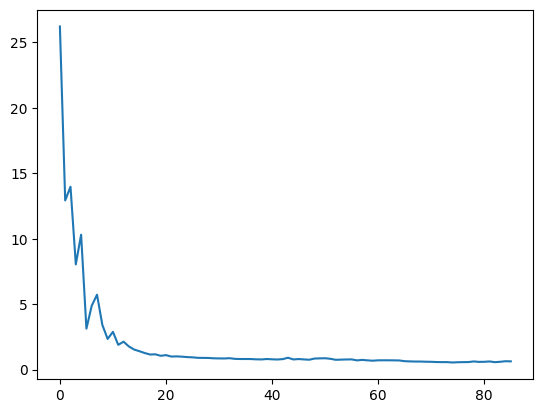

In [ ]:
# Plotting graph for MLPClassifier

loss_values = model.loss_curve_
plt.plot(loss_values)
plt.show()

In [ ]:
model1=MLPClassifier(alpha=0.001, batch_size=128, hidden_layer_sizes=(200, 200, 100, 50), learning_rate='adaptive', max_iter=500)

#Training the model
model1.fit(x_train,y_train)

model1.score(x_train, y_train)

0.9444444444444444

In [ ]:
#Predict for the test set
y_pred1=model1.predict(x_test)

#Calculate the accuracy of our model
accuracy1=accuracy_score(y_true=y_test, y_pred=y_pred1)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy1*100))

Accuracy: 73.44%


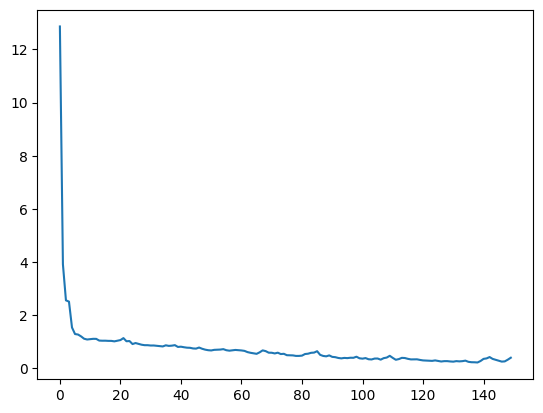

In [ ]:
# Plotting graph for MLPClassifier

loss_values1 = model1.loss_curve_
plt.plot(loss_values1)
plt.show()

In [ ]:
# Saving the tokenizer and the model:

import pickle

pickle.dump(model1, open('/content/drive/MyDrive/projects/Emotion_detection/emotion_classification-model.pkl', 'wb'))

In [ ]:
# uplaodede_file = "tet.waw"
# prediction[0] = 'Fearful'


In [ ]:
# - voice cloning

In [ ]:
# - Django App creation

In [ ]:
x_test[1]

array([-6.47691284e+02,  5.28175163e+01, -3.53246260e+00,  9.52361870e+00,
       -4.57315969e+00, -1.48879361e+00, -6.77537870e+00, -9.36155701e+00,
       -5.35051823e+00, -6.44741011e+00, -2.84276533e+00, -8.49749088e+00,
       -1.51545012e+00, -1.02491605e+00, -9.52684975e+00, -4.23719025e+00,
       -4.20171928e+00, -4.59749413e+00, -3.94530225e+00, -3.43245435e+00,
       -3.37658429e+00,  1.10328257e-01,  1.16314280e+00,  3.73533964e+00,
        4.15460587e+00,  3.07599640e+00,  3.55789113e+00,  4.69138002e+00,
        3.85106611e+00,  5.63062334e+00,  5.68155813e+00,  7.56928968e+00,
        5.09436607e+00,  6.29088211e+00,  2.27755666e+00,  6.99549139e-01,
        1.33844018e+00,  2.51562333e+00,  1.17957664e+00,  1.19791102e+00,
        6.00470722e-01,  5.83271801e-01,  5.90992212e-01,  5.63750744e-01,
        5.92185020e-01,  6.09457672e-01,  6.30620897e-01,  6.90428853e-01,
        6.90757334e-01,  6.66662335e-01,  6.51282132e-01,  6.64216578e-01,
        1.75357767e-04,  

In [ ]:
y_test[1]

'calm'

In [ ]:
y_pred[1]

'calm'

In [ ]:
import numpy as np
from scipy.io.wavfile import write

# Assume the array is a numpy array representing audio samples
audio_samples = x_test[1]  # Use your array

# Normalize the array if necessary (ensure values are within the appropriate range for audio)
max_val = np.max(np.abs(audio_samples))
normalized_audio = (audio_samples / max_val) * 32767  # For 16-bit audio

# Convert to 16-bit PCM format
audio_samples_int16 = normalized_audio.astype(np.int16)

# Save the array as a .wav file
write('output_audio.wav', 44100, audio_samples_int16)


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [ ]:
param_grid = {
    'hidden_layer_sizes': [(100,), (200, 200), (200, 200, 100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': [64, 128, 256],
    'max_iter': [200, 500, 1000]
}


In [ ]:
grid_search = GridSearchCV(estimator=MLPClassifier(), param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Run the grid search
grid_search.fit(x_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Best model
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found:  {'activation': 'tanh', 'alpha': 0.01, 'batch_size': 256, 'hidden_layer_sizes': (200, 200), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
Best cross-validation score:  0.783088455772114


In [ ]:
train_score = best_model.score(x_train, y_train)
print("Training accuracy: ", train_score)

# If you have a test set, evaluate the performance on it as well
test_score = best_model.score(x_test, y_test)
print("Test accuracy: ", test_score)


In [ ]:
pickle.dump(best_model, open('/content/drive/MyDrive/projects/Emotion_detection/emotion_det_model.pkl', 'wb'))

In [ ]:
import sklearn
sklearn.__version__

'1.3.2'